# Asset Model Loader

A notebook to demonstrate an interface with some of the features of the Asset Model Loader class

Authors: gavin.treseder@essentialenergy.com.au; illyse.schram@essentialenergy.com.au

In [1]:
import sys, os
sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import copy
import pof.demo as demo
import pprint
pp = pprint.PrettyPrinter(indent=4)

from pof.loader.asset_model_loader import AssetModelLoader

# Get the file location

In [2]:
filename = r"C:\Users\gtreseder\OneDrive - KPMG\Documents\3. Client\Essential Energy\Probability of Failure Model\pof\data\inputs\Asset Model - Demo.xlsx"


## Load the data

In [3]:
aml = AssetModelLoader()
data = aml.load(filename)

IndexError: list index out of range

In [4]:
from pof.component import Component
from pof.failure_mode import FailureMode
from pof.task import Inspection, Task

fm = FailureMode.load(demo.failure_mode_data['slow_aging'])
fm2 = FailureMode.load(data['pole']['fm']['termites'])

insp = Inspection.load(demo.inspection_data['instant'])
insp = Inspection.load(data['pole']['fm']['termites']['tasks']['inspection'])

Component.load(demo.component_data)
Component.load(data['pole'])



SyntaxError: invalid syntax (failure_mode.py, line 756)

In [6]:
pp.pprint(data['pole']['fm']['termites'])

{   'conditions': {   'external_diameter': {   'failed': 0.0,
                                               'name': 'external_diameter',
                                               'perfect': 250.0,
                                               'pf_curve': 'linear',
                                               'pf_interval': 8.0,
                                               'pf_std': 0.0},
                      'wall_thickness': {   'failed': 0.0,
                                            'name': 'wall_thickness',
                                            'perfect': 125.0,
                                            'pf_curve': 'linear',
                                            'pf_interval': 8.0,
                                            'pf_std': 0.0}},
    'name': 'termites',
    'tasks': {   'CAT1/2 replacement': {   'Level of Failure': 'component',
                                           'activity': 'ConditionTask',
                                           '

safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor not found
safety_factor no

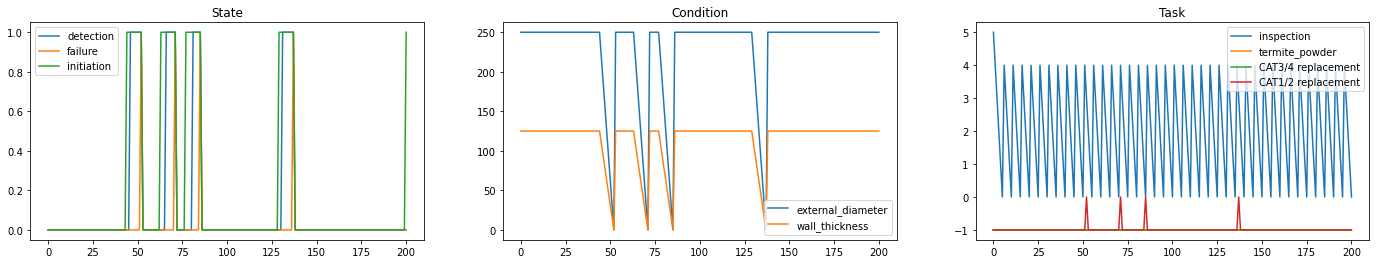

In [7]:
fm2.sim_timeline(200)
fm2.plot_timeline()

In [12]:
fm2.sim_timeline(200)
fm2.plot_timeline()

TypeError: ufunc 'bitwise_and' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
fm.tasks['inspection'].__dict__

In [ ]:
pp.pprint(data['pole']['fm']['termites'])

# Explore the data manually

In [ ]:
df = pd.read_excel(filename, sheet_name='Model Input', header=[0,1,2])
df.head()

In [ ]:
df = df.dropna(axis=1, how='all')
df.head()

In [ ]:
# Create keys
keys = dict(
    asset_model = ('asset_model', 'component', 'name'),
    #('indicator_model', 'indicator','name'),
    failure_model = ('failure_model', 'failure_mode', 'name'),
    task_model = ('task_model', 'task', 'name'),
    #('trigger_model', 'condition', 'name'), #TODO revist this one
    #('impact_model', 'condition', 'name'),
)

[('asset_model', 'component', 'name'),
 ('failure_model', 'failure_mode', 'name'),
 ('task_model', 'task', 'name')]

In [ ]:
def validate_keys(keys, df):
    missing_keys = [key for key in keys if key not in df.columns]

    if bool(missing_keys):
        print("Missing Keys: %s" %(missing_keys))
        return False
    else:
        return True

validate_keys(keys, df)

In [ ]:
def rename_duplicates(df, primary_key, foreign_key):
    """
    Warning: changes values of
    """
    if isinstance(primary_key, list):
        key_cols = primary_key + foreign_key
    mask_key = df[key_cols].notnull().any(axis=1)
    mask_dup = df.loc[mask_key, key_cols].ffill().duplicated(keep=False)

    mask = mask_key & mask_dup
    df.loc[mask, keys['task_model']] += '.' + df[key_cols].loc[mask].ffill().groupby(key_cols).cumcount().add(1).astype(str)

    


In [ ]:
# Check Failure Modes aren't duplicated
key_cols = [keys['asset_model'], keys['failure_model']]
mask_key = df[key_cols].notnull().any(axis=1)
mask_dup = df.loc[mask_key, key_cols].ffill().duplicated(keep=False)

mask = mask_key & mask_dup
df.loc[mask, keys['failure_model']] += '.' + df[key_cols].loc[mask].ffill().groupby(key_cols).cumcount().add(1).astype(str)

# Check Tasks aren't duplicated
key_cols = [keys['asset_model'], keys['failure_model'], keys['task_model']]
mask_key = df[key_cols].notnull().any(axis=1)
mask_dup = df.loc[mask_key, key_cols].ffill().duplicated(keep=False)

mask = mask_key & mask_dup
df.loc[mask, keys['task_model']] += '.' + df[key_cols].loc[mask].ffill().groupby(key_cols).cumcount().add(1).astype(str)

In [ ]:
def get_failure_mode_data(df_comp):

    fms_data = dict() #TODO
    fm_key = ('failure_model', 'failure_mode', 'name')
    failure_modes = df_comp[fm_key].unique()
    df_fms = df_comp[['failure_model', 'condition_model', 'task_model', 'trigger_model', 'impact_model']].set_index(fm_key)

    for fm in failure_modes:

        df_fm = df_fms.loc[[fm]]

        # Get the Task information
        tasks_data = get_task_data(df_fm)
        
        # Get the Distribution information
        dist_data = get_dist_data(df_fm)

        # Get the Condition information
        condition_data = get_condition_data(df_fm)

        fm_data = dict(
            name = fm,
            conditions = condition_data,
            tasks = tasks_data,
            untreated = dist_data,
        )
        fms_data.update({
            fm : fm_data,
        })

    return fms_data

In [ ]:
def get_condition_data(df_fm):
    #TODO update for new arrangement
    df_cond = df_fm['condition_model']
    conditions = df_cond['condition']['name'].dropna().to_numpy()
    cond_data = {cond : None for cond in conditions}
    return cond_data

In [ ]:
def get_dist_data(df_fm):

    df_dist = df_fm['failure_model'].dropna()
    df_dist.columns = df_dist.columns.droplevel()

    try:

        dist_data = df_dist.iloc[0].dropna().to_dict()
    except IndexError:
        dist_data = df_dist.dropna().to_dict()

    return dist_data

In [ ]:
def get_task_data(df_fm):
    """Takes a dataframe for a failure mode and returns a dict of task data
    """
    tasks_data = dict()
    task_key = ('task_model', 'task', 'name')
    tasks = df_fm[task_key].unique()
    df_tasks = df_fm[['task_model', 'trigger_model', 'impact_model']].set_index(task_key)

    for task in tasks:

        df_task = df_tasks.loc[[task]].dropna(axis=0, how='all')

        # Trigger information
        try:
            state = df_task['trigger_model']['state'].iloc[0].dropna().to_dict(),
        except:
            state = df_task['trigger_model']['state'].dropna().to_dict(),

        trigger_data = dict(
            state = state,
            condition = df_task['trigger_model']['condition'].dropna().set_index('name').to_dict('index')
        )

        # Impact information
        try:
            state = df_task['impact_model']['state'].iloc[0].dropna().to_dict(),
        except:
            state = df_task['impact_model']['state'].dropna().to_dict(),
            
        impact_data = dict(
            state = state,
            condition = df_task['impact_model']['condition'].dropna().set_index('name').to_dict('index')
        )

        # Tasks specific information
        df_tsi = df_task[('task_model')].dropna(how='all').dropna(axis=1)
        df_tsi.columns = df_tsi.columns.droplevel()

        task_data = df_tsi.to_dict('index') #TODO currently has too many vars
        try:
            task_data[task].update(dict(
                name=task,
                triggers=trigger_data,
                impacts = impact_data,
            ))
        except:
            task_data = dict(
                task = dict(
                    name=task,
                    triggers=trigger_data,
                    impacts = impact_data,
                )
            )

        tasks_data.update(task_data)

    return tasks_data

In [ ]:
def _get_component_data(df):
    comps_data = dict()

    # Get the Component information
    comp_key = ('asset_model', 'component', 'name')
    components = df[comp_key].dropna().unique()

    df_comps = df[['asset_model', 'failure_model', 'condition_model', 'task_model', 'trigger_model', 'impact_model']].set_index(comp_key)

    for comp in components:

        df_comp = df_comps.loc[[comp]]

        # Get the FailureMode information
        fm_data = get_failure_mode_data(df_comp)

        comp_data = dict(
            fm = fm_data,
        )

        comps_data.update({
            comp : comp_data
        })

    return comps_data

In [24]:
comp2 = _get_component_data(df)

# Flat version of what happens in the functions

In [26]:
comps_data = dict()

# Get the Component information
comp_key = ('asset_model', 'component', 'name')
components = df[comp_key].unique()

df_comps = df[['asset_model', 'failure_model', 'condition_model', 'task_model', 'trigger_model', 'impact_model']].set_index(comp_key)

for comp in ['pole']:

    df_comp = df_comps.loc[[comp]]

    fms_data = dict() #TODO
    fm_key = ('failure_model', 'failure_mode', 'name')
    failure_modes = df_comp[fm_key].unique()
    df_fms = df_comp[['failure_model', 'condition_model', 'task_model', 'trigger_model', 'impact_model']].set_index(fm_key)

    for fm in ['termites']:
        
        df_fm = df_fms.loc[[fm]]
        # Get the Task information
        tasks_data = get_task_data(df_fm)
        
        # Get the Distribution information
        df_dist = df_fm['failure_model'].dropna()
        df_dist.columns = df_dist.columns.droplevel()

        try:

            dist_data = df_dist.iloc[0].dropna().to_dict()
        except IndexError:
            dist_data = df_dist.dropna().to_dict()

        # Get the Condition information
        break

In [31]:
df_dist['name'] = df_dist.index
df_dist.to_dict('index')

{'termites': {'alpha': 50.0,
  'beta': 1.5,
  'gamma': 10.0,
  'pf_curve': 'linear',
  'pf_interval': 8.0,
  'pf_std': 1.0,
  'name': 'termites'}}

{}